<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Librairies" data-toc-modified-id="Librairies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Librairies</a></span></li><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fonctions</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Classification-supervisée" data-toc-modified-id="Classification-supervisée-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classification supervisée</a></span><ul class="toc-item"><li><span><a href="#Création-du-modèle-de-classification" data-toc-modified-id="Création-du-modèle-de-classification-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Création du modèle de classification</a></span></li><li><span><a href="#Approche-avec-préparation-initiale-des-images" data-toc-modified-id="Approche-avec-préparation-initiale-des-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Approche avec préparation initiale des images</a></span></li><li><span><a href="#Différente-séparation-des-données" data-toc-modified-id="Différente-séparation-des-données-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Différente séparation des données</a></span></li><li><span><a href="#Utilisation-de-la-data-augmentation" data-toc-modified-id="Utilisation-de-la-data-augmentation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Utilisation de la data augmentation</a></span><ul class="toc-item"><li><span><a href="#Avec-création-des-datasets-par-tensorflow" data-toc-modified-id="Avec-création-des-datasets-par-tensorflow-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Avec création des datasets par tensorflow</a></span></li><li><span><a href="#Avec-préparation-des-images-avant" data-toc-modified-id="Avec-préparation-des-images-avant-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Avec préparation des images avant</a></span></li></ul></li></ul></li></ul></div>

 # Import
 ## Librairies

In [1]:
# Builtin
import os, time
from os import listdir

# Data
import pandas as pd
import numpy as np

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from plot_keras_history import show_history, plot_history
%matplotlib inline

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Glob
from glob import glob

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Fonctions

In [13]:
def create_model_fct():
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False,
                   weights="imagenet",
                   input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy",
                  optimizer='rmsprop',
                  metrics=["accuracy"])

    print(model.summary())

    return model


def image_prep_fct(data):

    prepared_images = []

    for image_num in range(len(data['image_path'])):
        img = (load_img(data['image_path'][image_num], target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)

    return prepared_images_np


def conf_mat_transform(y_true, y_pred):

    conf_mat = confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


def dataset_fct(path,
                labels,
                batch_size=32,
                validation_split=0,
                data_type=None):

    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels=labels,
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=(224, 224),
        shuffle=True,
        seed=42,
        validation_split=validation_split,
        subset=data_type)

    return dataset


def create_model_augmentation_fct():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False,
                       weights="imagenet",
                       input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Rescaling(1. / 127.5, offset=-1.0),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())

    return model

def print_training_time(duration):
    if duration > 60:
        m = int(duration//60)
        s = int(duration - m*60)
        print(f"Temps d'entrainement : {m}m {s}s")

## Data

In [3]:
path = "../Data/Images/"
df = pd.read_csv("../Data/final.csv")
df.head()

,text,main_category,clean_text,image_name
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,elegance polyester multicolor abstract eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,cotton bath towel specification cotton bath to...,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,cotton terry face towel set key feature cotton...,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,royal fashion cotton printed king sized double...,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,print cotton floral king sized double key feat...,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [4]:
df["image_path"] = df["image_name"].apply(lambda x: path + x)

df.drop(columns=["text", "clean_text", "image_name"], axis=1, inplace=True)

df.head()

,main_category,image_path
0,Home Furnishing,../Data/Images/55b85ea15a1536d46b7190ad6fff8ce...
1,Baby Care,../Data/Images/7b72c92c2f6c40268628ec5f14c6d59...
2,Baby Care,../Data/Images/64d5d4a258243731dc7bbb1eef49ad7...
3,Home Furnishing,../Data/Images/d4684dcdc759dd9cdf41504698d737d...
4,Home Furnishing,../Data/Images/6325b6870c54cd47be6ebfbffa620ec...


In [5]:
le = preprocessing.LabelEncoder()
le.fit(df["main_category"])

df["label"] = le.transform(df["main_category"])

In [6]:
# 70% pour l'entraînement
train_df = df.sample(frac=0.7, random_state=42).reset_index(
    drop=True)  
test_df = df.drop(train_df.index).reset_index(drop=True)

In [7]:
print("Train :", train_df.shape)
print()
print("Test :", test_df.shape)

Train : (735, 3)

Test : (315, 3)


# Classification supervisée
## Création du modèle de classification

In [8]:
# Création du modèle
model1 = create_model_fct()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [9]:
# Création du callback
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

## Approche avec préparation initiale des images

In [8]:
images_np = image_prep_fct(train_df)
print(images_np.shape)
images_np_test = image_prep_fct(test_df)
print(images_np_test.shape)

C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet6-mnlG3Dat-py3.11\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(735, 224, 224, 3)
(315, 224, 224, 3)


In [10]:
X = images_np
y = to_categorical(train_df['label'])

X_test = images_np_test
y_test = to_categorical(test_df['label'])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  stratify=y,
                                                  test_size=0.25,
                                                  random_state=42)
X_train.shape

(551, 224, 224, 3)

In [13]:
# Entraîner sur les données d'entraînement (X_train, y_train)
start = time.time()
history1 = model1.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=64,
                      callbacks=callbacks_list,
                      validation_data=(X_val, y_val),
                      verbose=1)
duration = time.time() - start

Epoch 1/50


9/9 [==============================] - ETA: 0s - loss: 6.6721 - accuracy: 0.3975
Epoch 1: val_loss improved from inf to 1.52540, saving model to .\model1_best_weights.keras
9/9 [==============================] - 51s 6s/step - loss: 6.6721 - accuracy: 0.3975 - val_loss: 1.5254 - val_accuracy: 0.6957
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.9901 - accuracy: 0.6842
Epoch 2: val_loss improved from 1.52540 to 1.08922, saving model to .\model1_best_weights.keras
9/9 [==============================] - 44s 5s/step - loss: 1.9901 - accuracy: 0.6842 - val_loss: 1.0892 - val_accuracy: 0.7609
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.2306 - accuracy: 0.7713
Epoch 3: val_loss did not improve from 1.08922
9/9 [==============================] - 42s 5s/step - loss: 1.2306 - accuracy: 0.7713 - val_loss: 1.1756 - val_accuracy: 0.7174
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.8994 - accuracy: 0.8004
Epoch 4: val_l

In [32]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

18/18 [==============================] - 34s 2s/step - loss: 0.5323 - accuracy: 0.9129
Training Accuracy: 0.9129

6/6 [==============================] - 11s 2s/step - loss: 0.5873 - accuracy: 0.8913
Validation Accuracy:  0.8913

Temps d'entrainement : 8.0m 34s


In [15]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print()
print_training_time(duration)

Validation Accuracy :  0.8315
Test Accuracy       :  0.8667


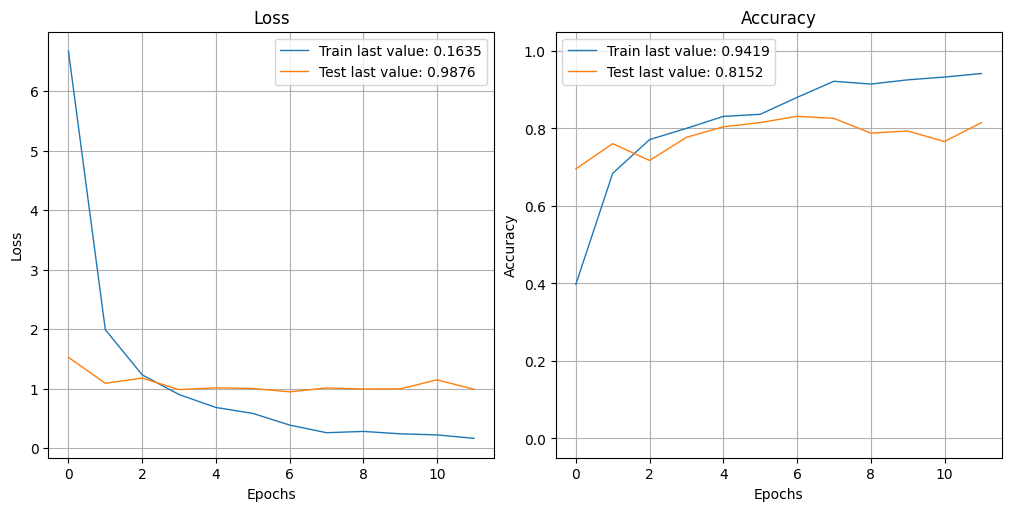

In [16]:
# Affichage de l'évolution des scores

show_history(history1)
plot_history(history1, path="Graphs/standard.png")
plt.close()

In [17]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 10s 2s/step
[3 3 2 0 2 1 2 6 0 6 2 5 4 1 2 2 4 3 4 4 5 3 4 5 5 5 5 2 0 1 3 4 0 3 3 3 4
 3 4 6 4 6 5 1 1 3 6 3 4 6 4 4 6 2 0 1 6 1 2 2 6 1 1 6 3 0 5 0 2 1 1 5 2 4
 6 2 2 5 6 5 1 1 1 5 4 6 1 2 3 3 4 1 4 4 0 3 0 2 5 4 4 0 0 4 2 2 0 3 5 0 0
 0 0 6 6 1 6 0 5 0 5 4 3 5 2 6 4 5 1 0 6 1 5 4 6 0 3 2 3 4 2 6 5 5 3 5 3 0
 1 4 4 0 3 3 5 1 6 6 3 6 5 6 6 2 2 2 4 2 1 4 6 3 3 3 0 5 1 0 5 6 6 1 2 2]

[3 3 2 0 2 3 2 6 4 6 2 5 4 1 2 3 0 3 4 4 5 4 3 5 5 5 5 2 0 1 3 3 4 3 3 3 4
 3 4 6 4 6 5 1 3 3 6 3 3 6 4 4 6 2 4 1 6 1 2 2 6 1 1 6 4 0 0 0 2 1 1 3 2 4
 6 2 2 5 6 5 2 1 3 5 0 6 1 2 4 3 3 1 4 0 0 3 0 2 5 4 4 0 2 4 2 2 0 3 5 0 3
 0 4 6 6 5 5 0 5 0 5 4 3 5 2 6 4 0 1 0 6 1 5 4 6 0 3 2 3 0 2 2 5 5 3 5 3 0
 1 4 4 0 3 3 5 1 6 6 0 6 3 6 6 2 2 2 4 2 1 4 6 3 3 3 0 5 1 0 5 6 6 3 2 2]


In [18]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[18  0  1  1  4  0  0]
 [ 0 18  1  4  0  1  0]
 [ 0  0 26  1  0  0  0]
 [ 1  0  0 23  3  0  0]
 [ 4  0  0  4 20  0  0]
 [ 2  0  0  2  0 22  0]
 [ 0  0  1  0  0  1 26]]


In [19]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[18  0  1  1  4  0  0]
 [ 0 18  1  4  0  1  0]
 [ 0  0 26  1  0  0  0]
 [ 1  0  0 23  3  0  0]
 [ 4  0  0  4 20  0  0]
 [ 2  0  0  2  0 22  0]
 [ 0  0  1  0  0  1 26]]

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        24
           1       1.00      0.75      0.86        24
           2       0.90      0.96      0.93        27
           3       0.66      0.85      0.74        27
           4       0.74      0.71      0.73        28
           5       0.92      0.85      0.88        26
           6       1.00      0.93      0.96        28

    accuracy                           0.83       184
   macro avg       0.85      0.83      0.83       184
weighted avg       0.85      0.83      0.83       184



## Différente séparation des données

In [20]:
# Création du modèle
model2 = create_model_fct()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
# Création du callback
model2_save_path1 = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path1,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [22]:
images_full = image_prep_fct(df)
print(images_full.shape)

C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet6-mnlG3Dat-py3.11\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


In [34]:
df["label"] = le.transform(df["main_category"])
X = images_full
y = to_categorical(df["label"])

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            stratify=y,
                                                            test_size=0.3,
                                                            random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  stratify=y_train_val,
                                                  test_size=0.25,
                                                  random_state=42)

In [35]:
# Entraîner sur les données d'entraînement (X_train, y_train)
start = time.time()
history2 = model2.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=64,
                      callbacks=callbacks_list,
                      validation_data=(X_val, y_val),
                      verbose=1)
duration = time.time() - start

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9492
Epoch 1: val_loss did not improve from 1.28299
9/9 [==============================] - 43s 5s/step - loss: 0.1393 - accuracy: 0.9492 - val_loss: 1.3604 - val_accuracy: 0.7663
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9673
Epoch 2: val_loss did not improve from 1.28299
9/9 [==============================] - 45s 5s/step - loss: 0.1180 - accuracy: 0.9673 - val_loss: 1.2945 - val_accuracy: 0.7663
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9728
Epoch 3: val_loss did not improve from 1.28299
9/9 [==============================] - 43s 5s/step - loss: 0.0725 - accuracy: 0.9728 - val_loss: 1.3142 - val_accuracy: 0.7609
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9655
Epoch 4: val_loss did not improve from 1.28299
9/9 [==============================] - 47s 5s/step - loss: 0.10

In [36]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

18/18 [==============================] - 34s 2s/step - loss: 0.0051 - accuracy: 0.9982
Training Accuracy: 0.9982

6/6 [==============================] - 11s 2s/step - loss: 1.3844 - accuracy: 0.7880
Validation Accuracy:  0.7880


In [37]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path1)

loss, accuracy = model2.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print()
print_training_time(duration)

Validation Accuracy :  0.7609
Test Accuracy       :  0.8000

Temps d'entrainement : 5m 12s


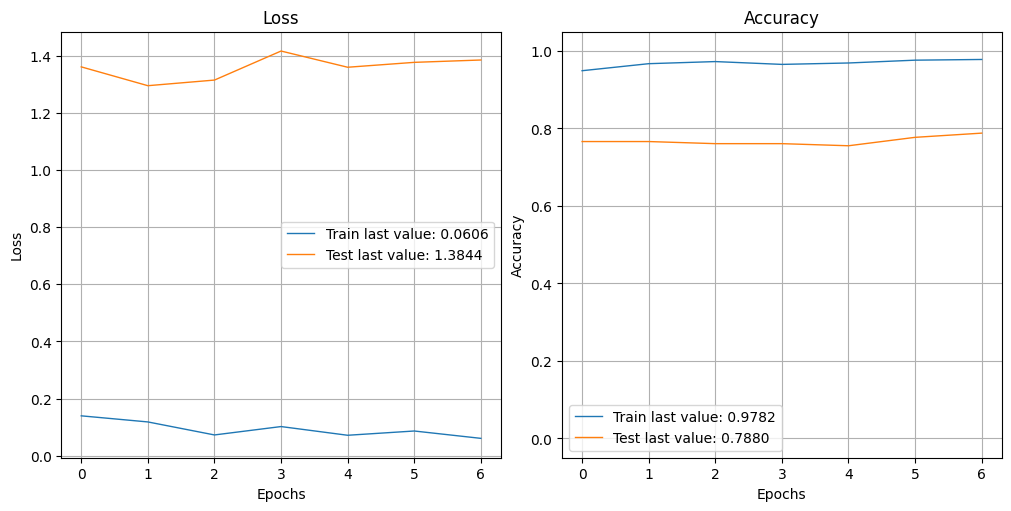

In [38]:
# Affichage de l'évolution des scores

show_history(history2)
plot_history(history2, path="Graphs/séparation.png")
plt.close()

In [39]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 11s 2s/step
[3 3 2 0 1 1 2 5 0 6 2 5 3 1 2 1 4 3 4 3 5 3 4 5 5 5 5 2 0 1 3 4 0 3 3 3 4
 3 4 6 4 6 5 1 1 3 6 3 4 6 3 4 6 2 0 1 6 1 2 1 6 1 0 6 3 0 5 0 1 1 1 5 2 4
 6 2 2 5 6 5 1 0 1 5 4 6 1 2 3 3 4 1 4 4 0 3 0 2 5 4 4 0 0 4 1 2 0 3 5 0 0
 0 0 6 6 1 6 0 5 0 5 4 2 4 2 6 4 5 1 0 6 1 5 4 5 0 2 2 3 4 2 6 5 5 3 5 3 0
 1 4 4 0 3 2 5 1 6 6 3 6 5 6 6 2 2 2 4 2 0 3 6 2 3 3 0 4 1 0 5 6 6 1 2 2]

[2 5 2 3 1 1 2 5 0 6 2 5 2 1 2 3 4 3 4 3 5 3 4 5 5 5 5 2 0 6 3 4 4 0 4 3 4
 0 4 6 4 6 5 3 1 3 6 3 4 6 3 4 6 2 4 1 6 1 2 1 6 1 0 6 3 0 5 4 1 1 1 5 5 4
 6 2 2 1 2 5 1 1 1 5 4 6 2 2 3 5 0 0 4 4 0 3 0 2 5 4 4 4 0 4 1 2 4 3 5 4 0
 0 0 6 6 2 6 4 5 0 5 4 4 4 2 6 4 2 1 3 0 1 5 4 5 0 2 2 1 4 2 6 5 5 4 0 3 4
 1 5 4 1 3 2 5 1 6 6 5 6 4 6 6 2 3 4 4 1 0 3 6 2 3 0 4 4 1 4 5 6 6 1 2 2]


In [40]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[13  2  0  2 10  0  0]
 [ 1 20  2  2  0  0  1]
 [ 0  1 21  1  2  1  0]
 [ 3  1  2 16  2  3  0]
 [ 1  0  0  0 24  1  0]
 [ 1  1  1  0  1 22  0]
 [ 1  0  1  0  0  0 24]]


In [41]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[13  2  0  2 10  0  0]
 [ 1 20  2  2  0  0  1]
 [ 0  1 21  1  2  1  0]
 [ 3  1  2 16  2  3  0]
 [ 1  0  0  0 24  1  0]
 [ 1  1  1  0  1 22  0]
 [ 1  0  1  0  0  0 24]]

              precision    recall  f1-score   support

           0       0.65      0.48      0.55        27
           1       0.80      0.77      0.78        26
           2       0.78      0.81      0.79        26
           3       0.76      0.59      0.67        27
           4       0.62      0.92      0.74        26
           5       0.81      0.85      0.83        26
           6       0.96      0.92      0.94        26

    accuracy                           0.76       184
   macro avg       0.77      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184



## Utilisation de la data augmentation
### Avec création des datasets par tensorflow

In [42]:
true_labels = df.sort_values("image_path")["label"].to_list()
print(len(true_labels))

1050


In [43]:
dataset_train = dataset_fct(path,
                            true_labels,
                            batch_size=64,
                            validation_split=0.4,
                            data_type="training")

dataset_val_test = dataset_fct(path,
                               true_labels,
                               batch_size=64,
                               validation_split=0.4,
                               data_type="validation")

val_batches = tf.data.experimental.cardinality(dataset_val_test)
dataset_val = dataset_val_test.skip((2 * val_batches) // 3)
dataset_test = dataset_val_test.take((2 * val_batches) // 3)

Found 1050 files belonging to 7 classes.
Using 630 files for training.
Found 1050 files belonging to 7 classes.
Using 420 files for validation.


In [44]:
model3 = create_model_augmentation_fct()

# Création du callback
model3_save_path = "./model3_best_weights.keras"
checkpoint = ModelCheckpoint(model3_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [45]:
start = time.time()
history3 = model3.fit(dataset_train,
                      batch_size=64,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1,
                      validation_data=dataset_val)
duration = time.time() - start

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 2.0445 - accuracy: 0.1968
Epoch 1: val_loss improved from inf to 2.01472, saving model to .\model3_best_weights.keras
10/10 [==============================] - 52s 5s/step - loss: 2.0445 - accuracy: 0.1968 - val_loss: 2.0147 - val_accuracy: 0.1585
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.4063
Epoch 2: val_loss did not improve from 2.01472
10/10 [==============================] - 51s 5s/step - loss: 1.6087 - accuracy: 0.4063 - val_loss: 2.1510 - val_accuracy: 0.1280
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3472 - accuracy: 0.5667
Epoch 3: val_loss did not improve from 2.01472
10/10 [==============================] - 50s 5s/step - loss: 1.3472 - accuracy: 0.5667 - val_loss: 2.3316 - val_accuracy: 0.1463
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.1555 - accuracy: 0.6333
Epoch 4: val_loss did not improve from 2.01472
10/1

In [46]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 38s 4s/step - loss: 0.7498 - accuracy: 0.7921
Training Accuracy   : 0.7921

3/3 [==============================] - 10s 3s/step - loss: 2.9555 - accuracy: 0.1524
Validation Accuracy :  0.1524


In [47]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print()
print_training_time(duration)

Validation Accuracy :  0.1768
Test Accuracy       :  0.1523

Temps d'entrainement : 5m 1s


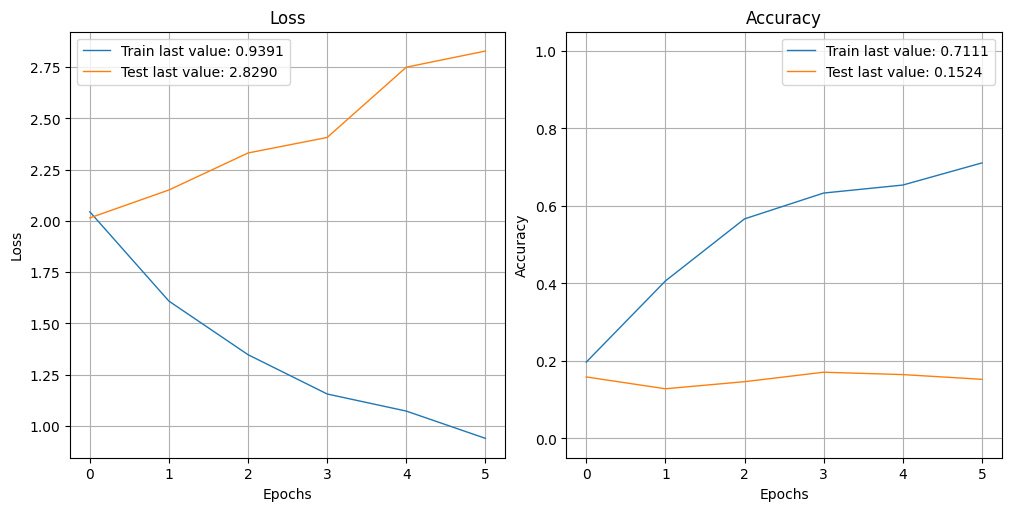

In [48]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="Graphs/datasets.png")
plt.close()

### Avec préparation des images avant

In [12]:
model4 = create_model_augmentation_fct()

# Création du callback
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                   

In [50]:
start = time.time()
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=64,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1,
                      validation_data=(X_val, y_val))
duration = time.time() - start

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.0034 - accuracy: 0.1960
Epoch 1: val_loss improved from inf to 1.67552, saving model to .\model4_best_weights.keras
9/9 [==============================] - 46s 5s/step - loss: 2.0034 - accuracy: 0.1960 - val_loss: 1.6755 - val_accuracy: 0.4946
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.6167 - accuracy: 0.4102
Epoch 2: val_loss improved from 1.67552 to 1.40738, saving model to .\model4_best_weights.keras
9/9 [==============================] - 44s 5s/step - loss: 1.6167 - accuracy: 0.4102 - val_loss: 1.4074 - val_accuracy: 0.6304
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.5481
Epoch 3: val_loss improved from 1.40738 to 1.22426, saving model to .\model4_best_weights.keras
9/9 [==============================] - 45s 5s/step - loss: 1.3661 - accuracy: 0.5481 - val_loss: 1.2243 - val_accuracy: 0.6522
Epoch 4/50
9/9 [==============================] - ETA: 0s -

In [51]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(X_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(X_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Training Accuracy   : 0.0000

6/6 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Validation Accuracy :  0.0000


In [52]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(X_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(X_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print()
print_training_time(duration)

Validation Accuracy :  0.0000
Test Accuracy       :  0.0000

Temps d'entrainement : 19m 50s


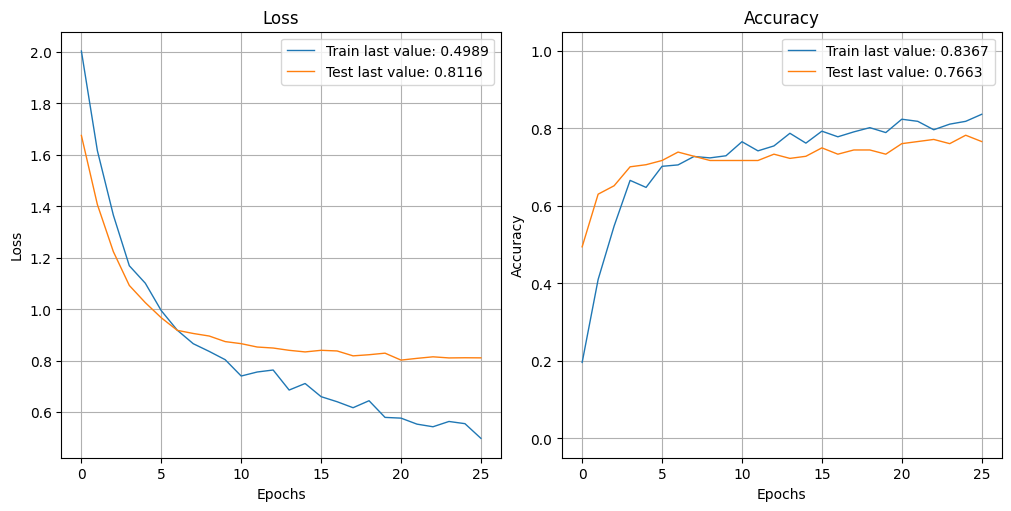

In [53]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="Graphs/augmentation.png")
plt.close()